# Exercise 4: Autoregressive Image Modeling
## Submission date: 18\05\2025, 23:59.

Submitted by:

 **Rami Sima'an**

 **Salam Qais**

<font color='red'>Before submission, please make sure that all the plots and results are present as a colab notebook file</font>


## Configurations and initializations

This section loads libraries and configurations for various tasks for this course

In [ ]:
## Standard libraries
import os
import math
import numpy as np
import pandas as pd

## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline
from IPython.display import set_matplotlib_formats
%config InlineBackend.figure_formats = ['svg', 'pdf']
from matplotlib.colors import to_rgb
import seaborn as sns

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

# Torchvision
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms

# Path to the folder where the datasets are/should be downloaded (e.g. MNIST)
DATASET_PATH = "../data"

# Path to the folder where the models are saved
CHECKPOINT_PATH = "./"

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

Using device cuda:0


<Figure size 640x480 with 0 Axes>

In [ ]:
# Convert images from 0-1 to 0-255 (integers).
def discretize(sample):
    return (sample * 255).to(torch.long)

# Transformations applied on each image => only make them a tensor
transform = transforms.Compose([transforms.ToTensor(), discretize])

# Loading the training dataset. We need to split it into a training and validation part
train_dataset = MNIST(root=DATASET_PATH, train=True, transform=transform, download=True)

#pl.seed_everything(42)
train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])

# Loading the test set
test_set = MNIST(root=DATASET_PATH, train=False, transform=transform, download=True)

# We define a set of data loaders that we can use for various purposes later.
train_loader = data.DataLoader(train_set, batch_size=128, shuffle=True, drop_last=True, pin_memory=True, num_workers=0)
val_loader = data.DataLoader(val_set, batch_size=128, shuffle=False, drop_last=False, num_workers=0)
test_loader = data.DataLoader(test_set, batch_size=128, shuffle=False, drop_last=False, num_workers=0)

print('Train size:', len(train_loader.dataset))
print('Validation size:', len(val_loader.dataset))
print('Test size:', len(test_loader.dataset))

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.12MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.10MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.32MB/s]

Train size: 50000
Validation size: 10000
Test size: 10000


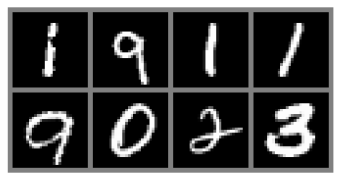

In [ ]:
def show_imgs(imgs):
    num_imgs = imgs.shape[0] if isinstance(imgs, torch.Tensor) else len(imgs)
    nrow = min(num_imgs, 4)
    ncol = int(math.ceil(num_imgs/nrow))
    imgs = torchvision.utils.make_grid(imgs, nrow=nrow, pad_value=128)
    imgs = imgs.clamp(min=0, max=255)
    np_imgs = imgs.cpu().numpy()
    plt.figure(figsize=(1.5*nrow, 1.5*ncol))
    plt.imshow(np.transpose(np_imgs, (1,2,0)), interpolation='nearest')
    plt.axis('off')
    plt.show()

show_imgs([train_set[i][0] for i in range(8)])

## Define Masked Cnvolutions

In [ ]:
class MaskedConvolution(nn.Module):

    def __init__(self, c_in, c_out, mask, **kwargs):
        """
        Implements a convolution with mask applied on its weights.
        Inputs:
            c_in - Number of input channels
            c_out - Number of output channels
            mask - Tensor of shape [kernel_size_H, kernel_size_W] with 0s where
                   the convolution should be masked, and 1s otherwise.
            kwargs - Additional arguments for the convolution
        """
        super().__init__()
        # For simplicity: calculate padding automatically
        kernel_size = (mask.shape[0], mask.shape[1])

        # Actual convolution
        self.conv = nn.Conv2d(c_in, c_out, kernel_size, padding='same', **kwargs)

        # Mask as buffer => it is no parameter but still a tensor of the module
        # (must be moved with the devices)
        self.register_buffer('mask', mask[None,None].to(device))

    def forward(self, x):
        self.conv.weight.data *= self.mask # Ensures zero's at masked positions
        return self.conv(x)

In [ ]:
class VerticalStackConvolution(MaskedConvolution):

    def __init__(self, c_in, c_out, kernel_size=3, mask_center=False, **kwargs):
        # Mask out all pixels below. For efficiency, we could also reduce the kernel
        # size in height, but for simplicity, we stick with masking here.
        mask = torch.ones(kernel_size, kernel_size)
        mask[kernel_size//2+1:,:] = 0

        # For the very first convolution, we will also mask the center row
        if mask_center:
            mask[kernel_size//2,:] = 0

        super().__init__(c_in, c_out, mask, **kwargs)

class HorizontalStackConvolution(MaskedConvolution):

    def __init__(self, c_in, c_out, kernel_size=3, mask_center=False, **kwargs):
        # Mask out all pixels on the left. Note that our kernel has a size of 1
        # in height because we only look at the pixel in the same row.
        mask = torch.ones(1,kernel_size)
        mask[0,kernel_size//2+1:] = 0

        # For the very first convolution, we will also mask the center pixel
        if mask_center:
            mask[0,kernel_size//2] = 0

        super().__init__(c_in, c_out, mask, **kwargs)

## PixelCNN without Gating and dilations

Instead of the GatedMaskConv from the tutorial, we defined a MaskedConvLayer for the model.

In [ ]:
class MaskedConvLayer(nn.Module):
    def __init__(self, c_in, kernel_size=3, flag=False):
        super().__init__()
        # vertical and horizontal convolutions
        self.vert_conv = VerticalStackConvolution(c_in, c_in, kernel_size=kernel_size, mask_center=flag)
        self.horiz_conv = HorizontalStackConvolution(c_in, c_in, kernel_size=kernel_size, mask_center=flag)

        # 1x1 convolution to inject vertical features into horizontal stack
        self.vert_to_horiz = nn.Conv2d(c_in, c_in, kernel_size=1)
        self.activation = nn.ReLU()

    def forward(self, v_stack, h_stack):

        v_out = self.vert_conv(v_stack)
        h_out = self.horiz_conv(h_stack) + self.vert_to_horiz(v_out)

        return self.activation(v_out), self.activation(h_out)



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

class PixelCNN(nn.Module):
    def __init__(self, c_in, c_hidden, n_layers=7, kernel_size=3, mask_center = False):
        super().__init__()


        self.conv_vstack = VerticalStackConvolution(c_in, c_hidden, kernel_size=kernel_size, mask_center=True)
        self.conv_hstack = HorizontalStackConvolution(c_in, c_hidden, kernel_size=kernel_size, mask_center=mask_center)


        self.conv_layers = nn.ModuleList([
            MaskedConvLayer(c_hidden, kernel_size=kernel_size, flag=False)
            for _ in range(n_layers)
        ])

        self.conv_out = nn.Conv2d(c_hidden, 256 * c_in, kernel_size=1)

    def forward(self, x):
        x = (x.float() / 255.0) * 2 - 1

        v_stack = self.conv_vstack(x)
        h_stack = self.conv_hstack(x)

        for layer in self.conv_layers:
            v_stack, h_stack = layer(v_stack, h_stack)

        out = self.conv_out(F.elu(v_stack + h_stack))
        B, _, H, W = out.shape
        out = out.view(B, 256, -1, H, W)
        out = out.permute(0, 2, 1, 3, 4)
        return out.squeeze(1) if x.shape[1] == 1 else out

    def calc_nll(self, x):
        logits = self.forward(x)  # [B, 256, H, W]
        target = x.squeeze(1)     # [B, H, W]
        loss = F.cross_entropy(logits, target, reduction='none')  # [B, H, W]
        bpd = loss.mean() / torch.log(torch.tensor(2.0))  # bits per dimension
        return bpd

    @torch.no_grad()
    def sample(self, img_shape, img=None):
        """
        Sampling function for the autoregressive model.
        Inputs:
            img_shape - Shape of the image to generate (B,C,H,W)
            img (optional) - If given, this tensor will be used as
                             a starting image. The pixels to fill
                             should be -1 in the input tensor.
        """
        device = next(self.parameters()).device
        if img is None:
            img = torch.zeros(img_shape, dtype=torch.long, device=device) - 1

        for h in tqdm(range(img_shape[2]), leave=False):
            for w in range(img_shape[3]):
                for c in range(img_shape[1]):
                    if (img[:, c, h, w] != -1).all().item():
                        continue
                    pred = self.forward(img)  # [B, 256, H, W]
                    probs = F.softmax(pred[:, :, h, w], dim=1)  # [B, 256]
                    sampled = torch.multinomial(probs, num_samples=1).squeeze(1)
                    img[:, c, h, w] = sampled
        return img

In [ ]:
inp_img = torch.zeros(1, 1, 11, 11).to(device)
inp_img.requires_grad_()

# took it from tutorial
def show_center_recep_field(img, out):
    """
    Calculates the gradients of the input with respect to the output center pixel,
    and visualizes the overall receptive field.
    Inputs:
        img - Input image for which we want to calculate the receptive field on.
        out - Output features/loss which is used for backpropagation, and should be
              the output of the network/computation graph.
    """
    # Determine gradients
    loss = out[0,:,img.shape[2]//2,img.shape[3]//2].sum() # L1 loss for simplicity
    loss.backward(retain_graph=True) # Retain graph as we want to stack multiple layers and show the receptive field of all of them
    img_grads = img.grad.abs()
    img.grad.fill_(0) # Reset grads

    # Plot receptive field
    img = img_grads.squeeze().cpu().numpy()
    fig, ax = plt.subplots(1,2)
    pos = ax[0].imshow(img)
    ax[1].imshow(img>0)
    # Mark the center pixel in red if it doesn't have any gradients (should be the case for standard autoregressive models)
    show_center = (img[img.shape[0]//2,img.shape[1]//2] == 0)
    if show_center:
        center_pixel = np.zeros(img.shape + (4,))
        center_pixel[center_pixel.shape[0]//2,center_pixel.shape[1]//2,:] = np.array([1.0, 0.0, 0.0, 1.0])
    for i in range(2):
        ax[i].axis('off')
        if show_center:
            ax[i].imshow(center_pixel)
    ax[0].set_title("Weighted receptive field")
    ax[1].set_title("Binary receptive field")
    plt.show()
    plt.close()


## **Receptive Field Visualization Across PixelCNN Layers**

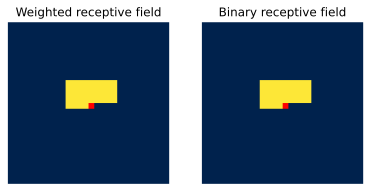

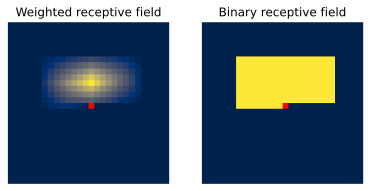

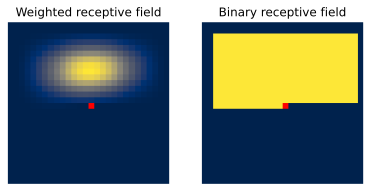

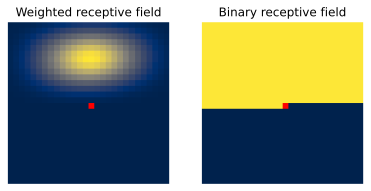

In [ ]:
for i in range(4):
    inp_img = torch.zeros(1, 1, 28, 28, requires_grad=True, device=device)
    v_stack = inp_img
    h_stack = inp_img

    for j in range(i + 1):
        flag = (j == 0)
        layer = MaskedConvLayer(c_in=1, kernel_size=9, flag=flag).to(device)
        with torch.no_grad():
            for p in layer.parameters():
                p.data.fill_(1.0)
        v_stack, h_stack = layer(v_stack, h_stack)

    show_center_recep_field(inp_img, h_stack)

Before you start training, you have to choose parameters for your model; How to choose the "most suitable"?

We can check the full receptive field of the model on an MNIST image of size $28\times 28$:

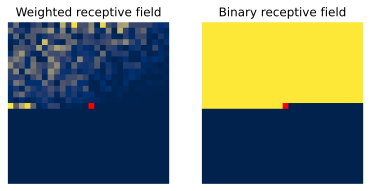

In [ ]:
test_model = PixelCNN(c_in=1, c_hidden=64, n_layers=8, kernel_size=9, mask_center=True).to('cpu')      # adjust according to your model
inp = torch.zeros(1,1,28,28).to('cpu')                    # do not remove the 'cpu' here
inp.requires_grad_()
out = test_model(inp)
show_center_recep_field(inp, out.squeeze(dim=2))
del inp, out, test_model

## Model Training

We chose:
- Number of layers is 8.
- Kernel size is 9

We trained for 15 epochs

In [ ]:
model = PixelCNN(c_in=1, c_hidden=64, n_layers=8,kernel_size=9, mask_center=True)       # adjust according to your model
print("Num params: {:,}".format(sum(p.numel() for p in model.parameters())))

model = torch.compile(model.to(device))

optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.99)

Num params: 3,005,952


In [ ]:
epochs = 15

Epoch 1/15, Train Loss: 1.7503, Val Loss: 1.2663


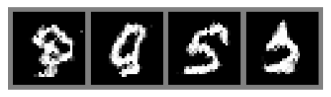

Epoch 2/15, Train Loss: 1.2168, Val Loss: 1.1573


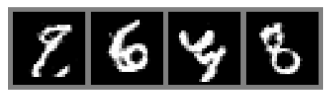

Epoch 3/15, Train Loss: 1.1394, Val Loss: 1.1310


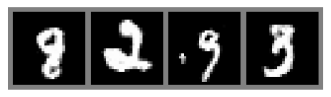

Epoch 4/15, Train Loss: 1.1198, Val Loss: 1.1146


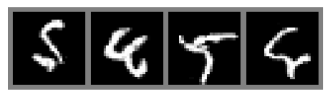

Epoch 5/15, Train Loss: 1.1078, Val Loss: 1.1060


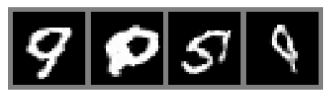

Epoch 6/15, Train Loss: 1.0996, Val Loss: 1.1006


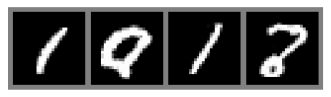

Epoch 7/15, Train Loss: 1.0941, Val Loss: 1.0943


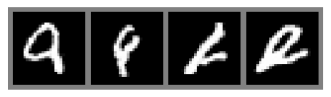

Epoch 8/15, Train Loss: 1.0911, Val Loss: 1.0886


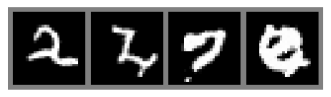

Epoch 9/15, Train Loss: 1.0860, Val Loss: 1.0767


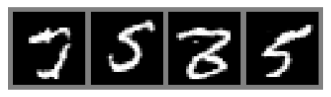

Epoch 10/15, Train Loss: 1.0805, Val Loss: 1.0660


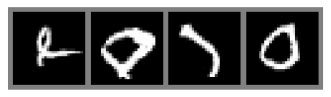

Epoch 11/15, Train Loss: 1.0641, Val Loss: 1.0568


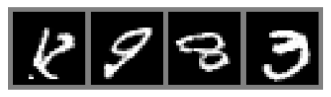

Epoch 12/15, Train Loss: 1.0552, Val Loss: 1.0515


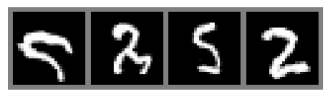

Epoch 13/15, Train Loss: 1.0517, Val Loss: 1.0539


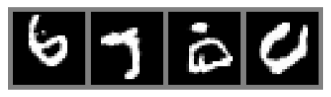

Epoch 14/15, Train Loss: 1.0409, Val Loss: 1.0498


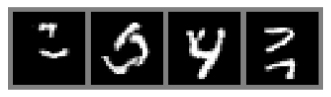

Epoch 15/15, Train Loss: 1.0350, Val Loss: 1.0396


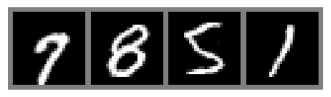

In [ ]:
# Training loop
train_bpd = []
val_bpd = []

for epoch in range(epochs):
    model.train()
    losses = []

    for imgs, _ in tqdm(train_loader, leave=False):
        imgs = imgs.to(device)
        optimizer.zero_grad()
        loss = model.calc_nll(imgs)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    train_bpd.append(np.mean(losses))
    scheduler.step()

    losses = []
    with torch.no_grad():
      for imgs, _ in tqdm(val_loader, leave=False):
          imgs = imgs.to(device)
          loss = model.calc_nll(imgs)
          losses.append(loss.item())

    val_bpd.append(np.mean(losses))

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_bpd[-1]:.4f}, Val Loss: {val_bpd[-1]:.4f}")

    if (epoch + 1) % 1 == 0:
       sampled_images = model.sample(img_shape=(4, 1, 28, 28))
       show_imgs(sampled_images)


In [ ]:
# Test loop
model.eval()
losses = []
for imgs, _ in tqdm(test_loader, leave=False):
    imgs = imgs.to(device)
    loss = model.calc_nll(imgs)
    losses.append(loss.item())

test_bpd = np.mean(losses)
print(f"Test Loss: {test_bpd:.4f}")


Test Loss: 1.0321


## **Save Trained Model**

In [ ]:
torch.save(model.state_dict(), 'pixelcnn_model.pth')

## **Load Saved Model**

In [ ]:
state_dict = torch.load('pixelcnn_model.pth')
new_state_dict = {k.replace('_orig_mod.', ''): v for k, v in state_dict.items()}
model_1 = PixelCNN(c_in=1, c_hidden=64, n_layers=8, kernel_size=9)
model_1.load_state_dict(new_state_dict)
model_1.to(device)
model_1.eval()

PixelCNN(
  (conv_vstack): VerticalStackConvolution(
    (conv): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1), padding=same)
  )
  (conv_hstack): HorizontalStackConvolution(
    (conv): Conv2d(1, 64, kernel_size=(1, 9), stride=(1, 1), padding=same)
  )
  (conv_layers): ModuleList(
    (0-7): 8 x MaskedConvLayer(
      (vert_conv): VerticalStackConvolution(
        (conv): Conv2d(64, 64, kernel_size=(9, 9), stride=(1, 1), padding=same)
      )
      (horiz_conv): HorizontalStackConvolution(
        (conv): Conv2d(64, 64, kernel_size=(1, 9), stride=(1, 1), padding=same)
      )
      (vert_to_horiz): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (activation): ReLU()
    )
  )
  (conv_out): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
)

## **Question 1**


To implement a version of the model without gated convolutions or dilation, we used only vertical and horizontal masked convolution stacks, as specified.

We made changes in two main classes: `MaskedConvLayer` and `PixelCNN`.


In `MaskedConvLayer` we implemented:
- `__init__`: <br>We define the following components:
  - **Vertical masked convolution**: <br>`self.vert_conv = VerticalStackConvolution(c_in, c_in, kernel_size=kernel_size)`
  <br>Processes pixels above the current pixel using a vertically masked kernel.<br>
  - **Horizontal masked convolution**:<br> `self.horiz_conv = HorizontalStackConvolution(c_in, c_in, kernel_size=kernel_size)`<br>Processes pixels to the left of the current pixel using a horizontally masked kernel.<br>

  - **1×1 convolution to inject vertical features into the horizontal stream:**:  <br>`self.vert_to_horiz = nn.Conv2d(c_in, c_in, kernel_size=1)`<br>This allows the horizontal path to access vertical context (from above) in a learnable way, which is essential to fix the blind spot in `PixelCNN`.<br>
  - **ReLU activation function**:
  ReLU is applied to both vertical and horizontal outputs for non-linearity.

-`forward(self, v_stack, h_stack)`: <br>The forward pass proceeds as follows:
  1. **Vertical convolution**: <br>
  `v_out = self.vert_conv(v_stack)`<br>
  This computes vertical context.<br>
  2.**Horizontal convolution with vertical injection**:<br>
  `h_out = self.horiz_conv(h_stack) + self.vert_to_horiz(v_out)`<br>The horizontal stack receives information from both its own past (h_stack) and the vertical stack (v_out, projected through vert_to_horiz). This setup allows the horizontal pathway to learn from both left and upper contexts, while still preserving the autoregressive property..<br>
  3. **Return activated outputs**:
  `return self.activation(v_out), self.activation(h_out)`<br>



In the `PixelCNN` class, we implemented a fully autoregressive model using only masked vertical and horizontal stacks, without any gated convolutions or dilation.

- `__init__`: <BR> We define the following components:<br>
  - **Initial vertical and horizontal masked convolutions**:<br>
```python
  self.conv_vstack = VerticalStackConvolution(c_in, c_hidden, kernel_size=kernel_size, mask_center=True)
  self.conv_hstack = HorizontalStackConvolution(c_in, c_hidden, kernel_size=kernel_size, mask_center=True)
```
These layers apply type `A` masks, meaning they mask the center pixel, which is necessary in the first layer to avoid peeking at the current pixel.
  - **Stack of masked convolution layers (residual blocks)**:
  ``` python
  self.conv_layers = nn.ModuleList([
    MaskedConvLayer(c_hidden, kernel_size=kernel_size)
    for _ in range(n_layers)
])
```
  Each `MaskedConvLayer` contains its own vertical and horizontal convolutions with type `B` masks (mask_center=False) and returns updated vertical and horizontal stacks. These layers progressively increase the receptive field while preserving the autoregressive property.
  - **Final 1x1 convolution for output**:
  ``` python
  self.conv_out = nn.Conv2d(c_hidden, 256 * c_in, kernel_size=1)
  ```
- `calc_nll(self, x)`:
This function calculates the bits per dimension (BPD) for a batch of images x:
  - `self.forward(x)` returns the predicted logits over 256 pixel values.
  - `x.squeeze(1)` removes the channel dimension to match target shape.
  - `F.cross_entropy(..., reduction='none')` computes pixel-wise loss.
  - `loss.mean()` averages over all pixels and images.
  - Dividing by log(2) converts the loss from nats to bits.


###**Plot of negative log likelihoods both for training and for validation during training**

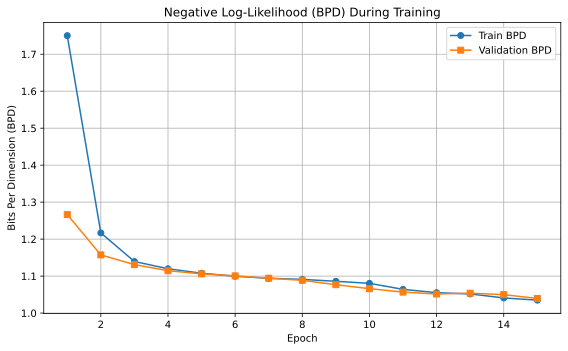

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs + 1), train_bpd, marker='o', label='Train BPD')
plt.plot(range(1, epochs + 1), val_bpd, marker='s', label='Validation BPD')
plt.title('Negative Log-Likelihood (BPD) During Training')
plt.xlabel('Epoch')
plt.ylabel('Bits Per Dimension (BPD)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### **Samples From The Trained Model**

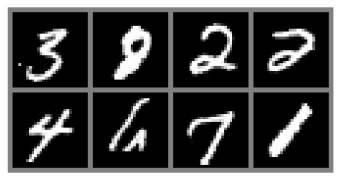

In [ ]:
sampled_images_1 = model.sample(img_shape=(8, 1, 28, 28))
show_imgs(sampled_images_1)

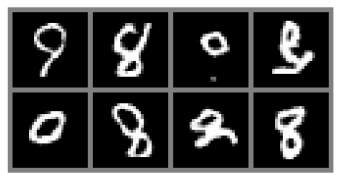

In [ ]:
sampled_images_2 = model.sample(img_shape=(8, 1, 28, 28))
show_imgs(sampled_images_2)

## **Question 2**
In this experiment, we disabled the center mask in the first horizontal stack layer, allowing the model to use the value of the current pixel in its own prediction. This breaks the autoregressive constraint, which requires that each pixel be predicted only from pixels above and to the left.

As a result, the model can “peek” at the current pixel during training, leading to lower loss and sharper samples. However, this is not valid at sampling time, because PixelCNN must generate pixels sequentially, without knowing the value of the pixel it’s currently predicting. This mismatch between training and sampling distributions can cause errors or inconsistencies during generation.

This behavior is controlled by the mask_center flag, which is passed only to the first horizontal convolution layer in the network (not to the vertical stack or the rest of the layers):

```python
self.conv_vstack = VerticalStackConvolution(c_in, c_hidden, kernel_size=kernel_size, mask_center=True)
self.conv_hstack = HorizontalStackConvolution(c_in, c_hidden, kernel_size=kernel_size, mask_center=mask_center)
```

By setting mask_center=`False` when constructing the model:
```python
casual_model = PixelCNN(c_in=1, c_hidden=64, n_layers=8, kernel_size=9, mask_center=False)
```


# Training Casual Model
We chose:
- Number of layers is 8.
- Kernel size is 9

We trained for 5 epochs, it was enough to see that the performace will be bad.


In [ ]:
casual_model = PixelCNN(c_in=1, c_hidden=64, n_layers=8,kernel_size=9, mask_center=False)       # adjust according to your model
print("Num params: {:,}".format(sum(p.numel() for p in casual_model.parameters())))

casual_model = torch.compile(casual_model.to(device))

optimizer = optim.Adam(casual_model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.99)

Num params: 3,005,952


In [ ]:
epochs = 5

Epoch 1/5, Train Loss: 1.7912, Val Loss: 1.2835


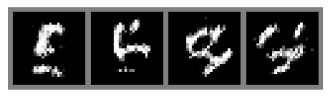

Epoch 2/5, Train Loss: 1.0645, Val Loss: 0.8032


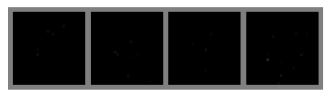

Epoch 3/5, Train Loss: 0.8535, Val Loss: 0.7020


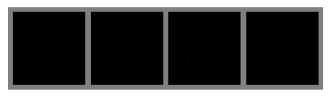

Epoch 4/5, Train Loss: 0.7331, Val Loss: 0.6900


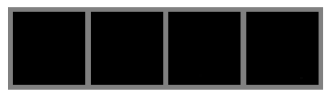

Epoch 5/5, Train Loss: 0.6377, Val Loss: 0.6498


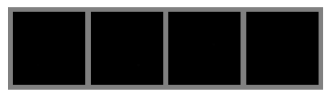

Test Loss: 0.6464


In [ ]:
# Training loop
train_bpd = []
val_bpd = []

for epoch in range(epochs):
    casual_model.train()
    losses = []

    for imgs, _ in tqdm(train_loader, leave=False):
        imgs = imgs.to(device)
        optimizer.zero_grad()
        loss = casual_model.calc_nll(imgs)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    train_bpd.append(np.mean(losses))
    scheduler.step()

    losses = []
    with torch.no_grad():
      for imgs, _ in tqdm(val_loader, leave=False):
          imgs = imgs.to(device)
          loss = casual_model.calc_nll(imgs)
          losses.append(loss.item())

    val_bpd.append(np.mean(losses))

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_bpd[-1]:.4f}, Val Loss: {val_bpd[-1]:.4f}")

    if (epoch + 1) % 1 == 0:
       sampled_images = casual_model.sample(img_shape=(4, 1, 28, 28))
       show_imgs(sampled_images)

# Test loop
casual_model.eval()
losses = []
for imgs, _ in tqdm(test_loader, leave=False):
    imgs = imgs.to(device)
    loss = casual_model.calc_nll(imgs)
    losses.append(loss.item())

test_bpd = np.mean(losses)
print(f"Test Loss: {test_bpd:.4f}")

## **Save Trained Casual Model**

In [ ]:
torch.save(casual_model.state_dict(), 'casual_pixelcnn_model.pth')

## **Load Trained Casual Model**

In [ ]:
state_dict = torch.load('casual_pixelcnn_model.pth')
new_state_dict = {k.replace('_orig_mod.', ''): v for k, v in state_dict.items()}
model_1 = PixelCNN(c_in=1, c_hidden=64, n_layers=8, kernel_size=9)
model_1.load_state_dict(new_state_dict)
model_1.to(device)
model_1.eval()

### **Compute Loss Of Non-Casual PixelCNN Model**

In [ ]:
# Test loop
casual_model.eval()
casual_losses = []
for imgs, _ in tqdm(test_loader, leave=False):
    imgs = imgs.to(device)
    loss = casual_model.calc_nll(imgs)
    casual_losses.append(loss.item())

test_bpd = np.mean(casual_losses)
print(f"Test Loss: {test_bpd:.4f}")

Test Loss: 0.6464


###**Plot of negative log likelihoods both for training and for validation during training**

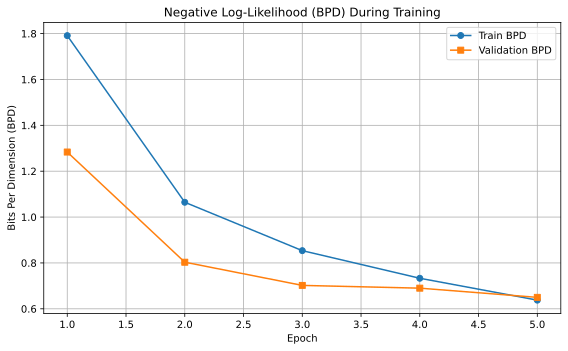

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs + 1), train_bpd, marker='o', label='Train BPD')
plt.plot(range(1, epochs + 1), val_bpd, marker='s', label='Validation BPD')
plt.title('Negative Log-Likelihood (BPD) During Training')
plt.xlabel('Epoch')
plt.ylabel('Bits Per Dimension (BPD)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### **Samples From Casual Trained Model**

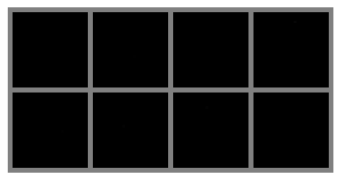

In [ ]:
casual_sampled_images = casual_model.sample(img_shape=(8, 1, 28, 28))
show_imgs(casual_sampled_images)

## **Question 3**

---



---




In [ ]:
# used for section (a) and (b)
imgs, _ = next(iter(train_loader))  # real images
imgs = imgs.to(device)

with torch.no_grad():
    model.eval()
    out = model(imgs)
    probs = F.softmax(out, dim=1)

### **Section A**

---
This is **EASY**.<BR>
In this section, we find the probability of each possible value (0–255) for the first pixel at position (0,0). This is **easy** because PixelCNN starts generating from this pixel, and it doesn’t depend on any others.

We give the model an empty image (all pixels set to -1) and ask it to predict the first pixel. The model gives us scores for each value, and we use softmax to turn them into probabilities. This gives us the full distribution for pixel (0,0) exactly.


In [ ]:
@torch.no_grad()
def get_marginal_first_pixel(model, img_shape=(1, 1, 28, 28)):
    device = next(model.parameters()).device

    img = torch.full(img_shape, -1, dtype=torch.long, device=device)
    # predict logits
    logits = model(img)
    # get probability at (0,0)
    probs = F.softmax(logits[:, :, 0, 0], dim=1)
    return probs[0].cpu().numpy()

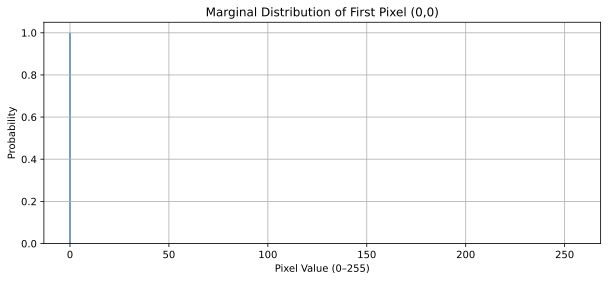

In [ ]:
# marginal probability of the first pixel
probs = get_marginal_first_pixel(model_1)

# plot it
plt.figure(figsize=(10, 4))
plt.bar(range(256), probs)
plt.title("Marginal Probability of First Pixel (0,0)")
plt.xlabel("Pixel Value (0–255)")
plt.ylabel("Probability")
plt.grid(True)
plt.show()

Another approach is to get batch of real images, applying softmax to the logits, and then averaging the output probabilities.

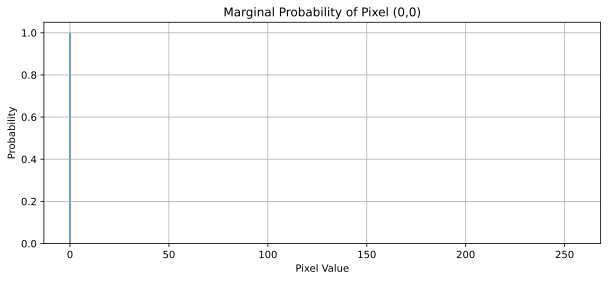

In [ ]:

px_probs = probs[:, :, 0, 0]

# marginal probability of the first pixel
marginal_000 = px_probs.mean(dim=0).cpu().numpy()

# plot it
plt.figure(figsize=(10, 4))
plt.bar(range(256), marginal_000)
plt.title("Marginal Probability of Pixel (0,0)")
plt.xlabel("Pixel Value")
plt.ylabel("Probability")
plt.grid(True)
plt.show()

Either way we get the same reuslts



---



---


### **Section B**


---



---


This section is **HARD**.<BR>
In this part, we want to estimate the probability distribution over all possible values (0–255) for the pixel in the center of the image at position (14,14), without knowing any other pixel values, we want to compute the marginal probability $p(x_{14,14})$.

This is **harder** than Section (a), because PixelCNN models each pixel based on the ones above and to the left. To address this, we use a Monte Carlo approximation:
- We generate multiple random images by initializing them as fully masked (all pixels set to -1), and then let the model sample pixels one-by-one up to position (14,14).
- For each sampled image, we compute the model’s predicted probability distribution at pixel (14,14) using softmax.
- We repeat this process many times and average the predictions, which gives a Monte Carlo estimate of the marginal distribution:
$p(x_{14,14}) \approx \frac{1}{N} \sum_{i=1}^{N} p(x_{14,14} \mid x_{<14,14}^{(i)}$)


In [ ]:
@torch.no_grad()
def estimate_marginal_middle_pixel(model, num_samples=100):
    device = next(model.parameters()).device
    img_shape = (1, 1, 28, 28)
    counts = torch.zeros(256, device=device)

    for _ in range(num_samples):
        img = torch.full(img_shape, -1, dtype=torch.long, device=device)
        # sample all pixels up to (14,14)
        for h in range(28):
            for w in range(28):
                if h > 14 or (h == 14 and w > 14):
                    # skip future pixels
                    continue
                for c in range(1):
                    # one channel
                    if (img[:, c, h, w] != -1).all():
                        continue

                    pred = model(img)
                    # apply softmax to prediction
                    probs = F.softmax(pred[:, :, h, w], dim=1)
                    # choose random sample
                    sampled = torch.multinomial(probs, 1).squeeze(1)
                    # assign sampled pixel
                    img[:, c, h, w] = sampled

        # after filling up to (14,14), get its distribution
        logits = model(img)
        px_probs = F.softmax(logits[:, :, 14, 14], dim=1)
        counts += px_probs[0]

    probs = (counts / num_samples).cpu().numpy()
    return probs

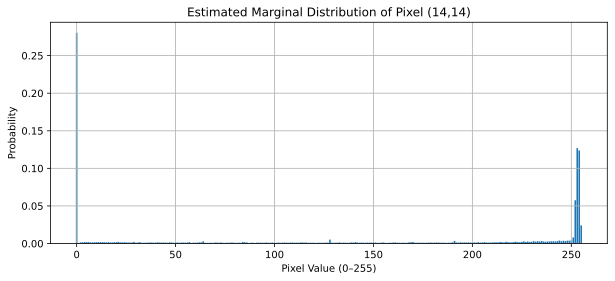

In [ ]:
probs = estimate_marginal_middle_pixel(model_1, num_samples=100)

plt.figure(figsize=(10, 4))
plt.bar(range(256), probs)
plt.title("Estimated Marginal Distribution of Pixel (14,14)")
plt.xlabel("Pixel Value (0–255)")
plt.ylabel("Probability")
plt.grid(True)
plt.show()

The Monte Carlo method above is accurate but computationally expensive, since it requires generating many full or partial samples from the model.

As a faster alternative, we can use a batch of real images from the training set, and compute the model’s predicted probability distribution for pixel (14,14) in each image. Then, we average the predicted distributions across the batch to approximate the marginal:

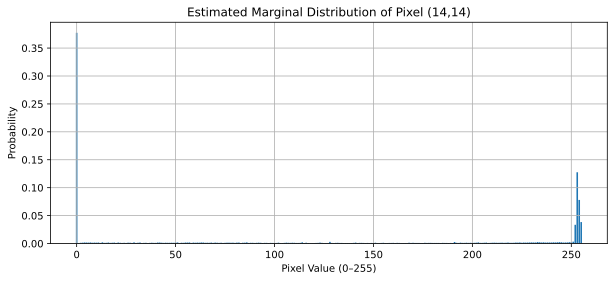

In [ ]:

px_probs = probs[:, :, 14, 14]
marginal_1414 = px_probs.mean(dim=0).cpu().numpy()
plt.figure(figsize=(10, 4))
plt.bar(range(256), marginal_1414)
plt.title("Estimated Marginal Distribution of Pixel (14,14)")
plt.xlabel("Pixel Value (0–255)")
plt.ylabel("Probability")
plt.grid(True)
plt.show()


As we can see, both approaches produce very similar results for the marginal distribution of pixel (14,14), confirming that using real image contexts from the dataset is a valid and much faster approximation compared to the full Monte Carlo sampling method.



---



---


### **Section C**


---



---

It is **EASY**<BR>
In this section, we compute the probability of the center pixel (14,14) assuming that all pixels before it (above and to the left) are known.

PixelCNN is trained autoregressively, so this setup matches its natural generation order. We simulate this by starting with a fully masked image, and then sampling pixel-by-pixel in raster order up to and including pixel (14,14).

Once pixel (14,14) is reached, we extract the predicted distribution over its possible values using softmax. This gives us the conditional probability of the middle pixel given its past context. This is an exact and efficient computation using the model.


In [ ]:
@torch.no_grad()
def conditional_middle_pixel_given_past(model):
    device = next(model.parameters()).device
    img = torch.full((1, 1, 28, 28), -1, dtype=torch.long, device=device)

    # fill all pixels up to (14,14)
    for h in range(28):
        for w in range(28):
            if h > 14 or (h == 14 and w > 14):
                continue
            # same as before
            pred = model(img)
            probs = F.softmax(pred[:, :, h, w], dim=1)
            sampled = torch.multinomial(probs, num_samples=1).squeeze(1)
            img[:, 0, h, w] = sampled

    # predict pixel (14,14)
    pred = model(img)
    px_probs = F.softmax(pred[:, :, 14, 14], dim=1).cpu().numpy()[0]
    return px_probs

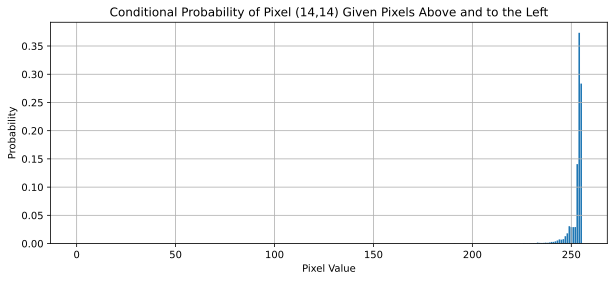

In [ ]:
probs = conditional_middle_pixel_given_past(model_1)

plt.figure(figsize=(10, 4))
plt.bar(range(256), probs)
plt.title("Conditional Probability of Pixel (14,14) Given Pixels Above and to the Left")
plt.xlabel("Pixel Value")
plt.ylabel("Probability")
plt.grid(True)
plt.show()

**Another approach is**, we take a batch of real images and keep only the pixels above and to the left of pixel (14,14). All other pixels are set to -1 (masked). Then, we run the model on these images and get the predicted probability for pixel (14,14) in each image.

We average all the predictions to get a smooth and reliable estimate of:
$p(x_{14,14} \mid x_{<14,14})$

This shows how the model predicts the center pixel using only the pixels it’s allowed to see (the ones before it). The result gives us a good estimate of how the model works with real image data

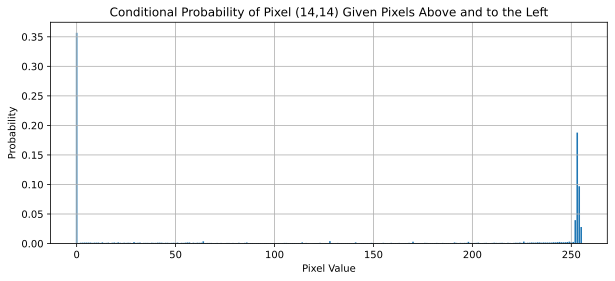

In [ ]:
@torch.no_grad()
def conditional_middle_pixel_batch(model, img_batch):

    device = next(model.parameters()).device
    B = img_batch.size(0)
    x = torch.full_like(img_batch, -1)

    # fill past pixels from each image in the batch
    for h in range(28):
        for w in range(28):
            if h < 14 or (h == 14 and w <= 14):
                x[:, 0, h, w] = img_batch[:, 0, h, w]

    logits = model(x)
    probs = F.softmax(logits[:, :, 14, 14], dim=1)
    avg_probs = probs.mean(dim=0).cpu().numpy()
    return avg_probs

probs = conditional_middle_pixel_batch(model, imgs)

plt.figure(figsize=(10, 4))
plt.bar(range(256), probs)
plt.title("Conditional Probability of Pixel (14,14) Given Pixels Above and to the Left")
plt.xlabel("Pixel Value")
plt.ylabel("Probability")
plt.grid(True)
plt.show()

I think we got different results because in the first approach we sampled all the way to pixel (14,14), which mimics how the model generates. And in the second approach we used a batch of real images, which reflects dataset behavior. So it’s okay to be different — they’re just showing different views of the same model.

### **Section D**

This section will be **hard**.<br> PixelCNN is a causal model trained to predict each pixel from pixels above and to the left. It cannot access pixels that come after a given position (like those below and to the right). This makes it impossible to compute the conditional distribution of the middle pixel (14,14) given pixels below and to the right using the model directly.<br>

There is two ways to overcome this issue:
- **Monte Carlo Approximation**: We take a real image and fix all the future pixels (those after (14,14)). Then we randomly sample all the unknown pixels before (14,14) using the model.
After that, we use the model to predict the probability of the middle pixel. We repeat this many times and average the results.
- **Gibbs Sampling**: We also fix the future pixels from a real image.
Then we resample all the other pixels over and over, one at a time, using the model. This helps the rest of the image slowly adjust to match the fixed future pixels.
After enough steps, we collect the model’s predictions at pixel (14,14), and average them to get the final result.


####**Monte Carlo Approximation**

In [ ]:
@torch.no_grad()
def approximate_conditional_middle_given_future(model, real_img, num_samples=100):

    device = next(model.parameters()).device
    counts = torch.zeros(256, device=device)

    for _ in range(num_samples):
        img = torch.full((1, 1, 28, 28), -1, dtype=torch.long, device=device)

        # fix the future pixels from the real image
        for h in range(28):
            for w in range(28):
                if h > 14 or (h == 14 and w > 14):
                    img[:, 0, h, w] = real_img[0, 0, h, w]

        # sample the unknown past
        for h in range(28):
            for w in range(28):
                if h > 14 or (h == 14 and w > 14):
                    # skip known future
                    continue

                pred = model(img)
                probs = F.softmax(pred[:, :, h, w], dim=1)
                sampled = torch.multinomial(probs, 1).squeeze(1)
                img[:, 0, h, w] = sampled

        # get conditional distribution at pixel (14,14)
        pred = model(img)
        px_probs = F.softmax(pred[:, :, 14, 14], dim=1)
        counts += px_probs[0]

    final_probs = (counts / num_samples).cpu().numpy()
    return final_probs

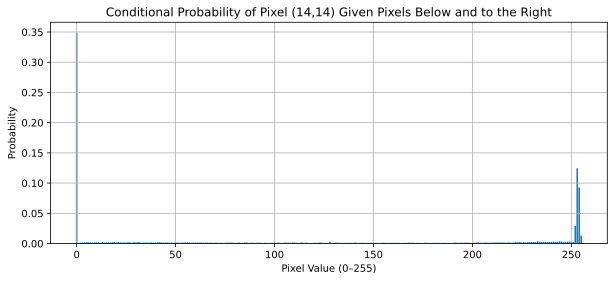

In [ ]:
imgs, _ = next(iter(train_loader))
real_img = imgs[0:1].to(device)

probs = approximate_conditional_middle_given_future(model_1, real_img)


plt.figure(figsize=(10, 4))
plt.bar(range(256), probs)
plt.title("Conditional Probability of Pixel (14,14) Given Pixels Below and to the Right")
plt.xlabel("Pixel Value (0–255)")
plt.ylabel("Probability")
plt.grid(True)
plt.show()

### **Gibbs Sampling**

In [ ]:
@torch.no_grad()
def conditional_14_14_given_future(model, future_img, num_steps=300, burnin=100):
    device = next(model.parameters()).device
    x = torch.randint(0, 256, (1, 1, 28, 28), dtype=torch.long, device=device)

    # fix future pixels
    for i in range(28):
        for j in range(28):
            if i > 14 or (i == 14 and j > 14):
                # set fixed future value
                x[0, 0, i, j] = future_img[0, 0, i, j]

    samples = []

    for step in range(num_steps):
        for i in range(28):
            for j in range(28):
                if i > 14 or (i == 14 and j > 14):
                    # skip future pixels
                    continue

                logits = model(x)
                probs = F.softmax(logits[0, :, i, j], dim=0)
                x[0, 0, i, j] = torch.multinomial(probs, 1)

        if step >= burnin:
            logits = model(x)
            px_probs = F.softmax(logits[0, :, 14, 14], dim=0)
            samples.append(px_probs.cpu())

    avg_probs = torch.stack(samples).mean(dim=0).numpy()
    return avg_probs

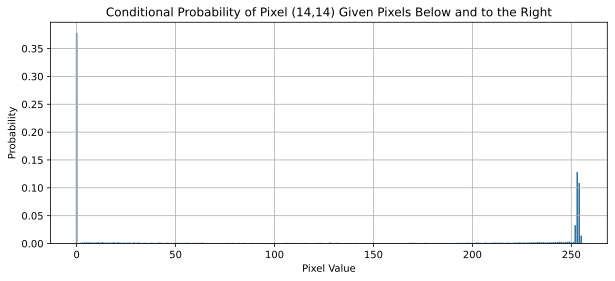

In [ ]:
# use real image for future pixels
imgs, _ = next(iter(train_loader))
future_img = imgs[0:1].to(device)

probs = conditional_14_14_given_future(model, future_img)
plt.figure(figsize=(10, 4))
plt.bar(range(256), probs)
plt.title("Conditional Probability of Pixel (14,14) Given Pixels Below and to the Right")
plt.xlabel("Pixel Value")
plt.ylabel("Probability")
plt.grid(True)
plt.show()



---



---


### **Section E**


---



---


This section is **HARD**.<br>
We want to find the probability of the middle pixel (14,14) when we already know the values of all the other pixels in the image.

PixelCNN is a model that can only see the pixels before the current one (above and to the left), so it can’t use the future pixels (to the right and below) to predict (14,14). Because of that, we can’t just mask (14,14) and ask the model for a prediction.

Instead, we use **Gibbs sampling**. We fix all pixels in the image except (14,14), and then we resample (14,14) many times using the model. Each time, we record the model’s predicted probabilities.

In the end, we average these predictions to get a good estimate of the real conditional probability of (14,14), using all the other pixels in the image.

In [ ]:
@torch.no_grad()
def conditional_14_14_given_all_others(model, real_img, num_samples=100):

    device = next(model.parameters()).device
    x = real_img.clone().to(device)  # full real image
    samples = []

    for _ in range(num_samples):
        # predict distribution at (14,14)
        logits = model(x)
        probs = F.softmax(logits[0, :, 14, 14], dim=0)
        samples.append(probs.cpu())

        # sample from it and update x
        sampled_val = torch.multinomial(probs, 1)
        x[0, 0, 14, 14] = sampled_val

    avg_probs = torch.stack(samples).mean(dim=0).numpy()
    return avg_probs

We tested the method on three different real images. Each image gave a different result, which is what we expected. Since the other pixels are different in each image, the model gives a different prediction for pixel (14,14).

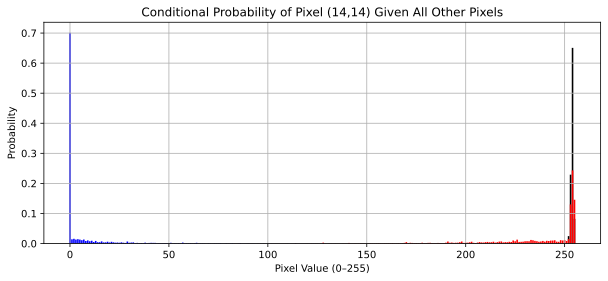

In [ ]:
real_img, _ = next(iter(train_loader))
real_img_1 = real_img[0:1].to(device)
real_img_2 = real_img[1:2].to(device)
real_img_3 = real_img[2:3].to(device)
probs_1 = conditional_14_14_given_all_others(model_1, real_img_1)
probs_2 = conditional_14_14_given_all_others(model_1, real_img_2)
probs_3 = conditional_14_14_given_all_others(model_1, real_img_3)
plt.figure(figsize=(10, 4))
plt.bar(range(256), probs_1, color='black')
plt.bar(range(256), probs_2, color='red')
plt.bar(range(256), probs_3, color='blue')
plt.title("Conditional Probability of Pixel (14,14) Given All Other Pixels")
plt.xlabel("Pixel Value (0–255)")
plt.ylabel("Probability")
plt.grid(True)
plt.show()



---



---


### **Section F**


---



---

This is **EASY**.<BR>
In this section, we want to generate the bottom half of an image using the model, while keeping the top half fixed. This means we are sampling:
$p(x_{\text{bottom}} \mid x_{\text{top}})$

We do this by taking a real image from the dataset and keeping the top 14 rows unchanged. The bottom 14 rows  are unknown, so we set them to -1 and then use the model to sample each pixel one by one in raster order (left to right, top to bottom).

Since PixelCNN is an autoregressive model, it predicts each pixel based on the ones above and to the left. This means it can naturally generate the bottom pixels using the known top part as context.

In the end, we get a full image where the top half is real, and the bottom half is generated by the model based on the top.


In [ ]:
@torch.no_grad()
def sample_bottom_half_given_top(model, real_img):

    device = next(model.parameters()).device
    x = torch.full_like(real_img, -1)

    # copy the top half from the real image
    x[:, :, :14, :] = real_img[:, :, :14, :]

    # sample bottom half
    for i in range(14, 28):
        for j in range(28):
            logits = model(x)
            probs = F.softmax(logits[0, :, i, j], dim=0)
            sampled = torch.multinomial(probs, 1)
            x[0, 0, i, j] = sampled

    return x

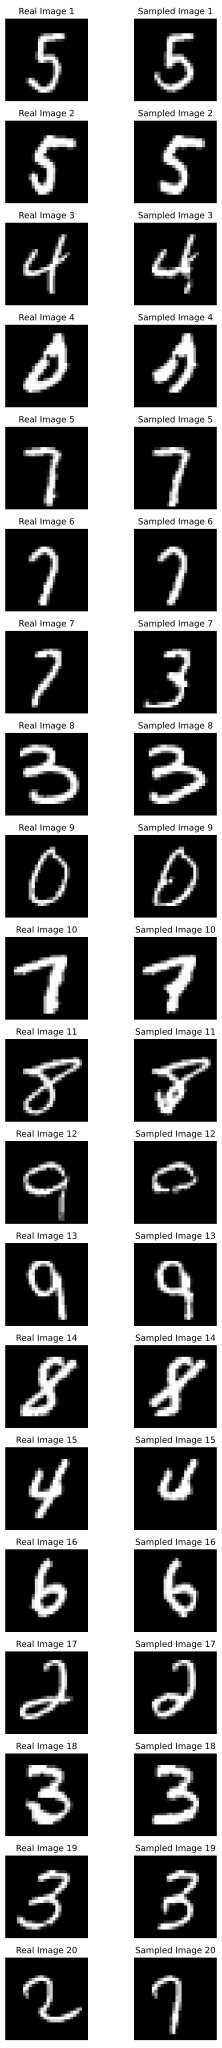

In [ ]:
imgs, _ = next(iter(train_loader))

imgs = imgs[:20].to(device)
# slice images
real_imgs = [imgs[i:i+1] for i in range(20)]

# sample images given top half
sampled_imgs = [sample_bottom_half_given_top(model_1, real_img) for real_img in real_imgs]

# show Real images and Sampled images
fig, axs = plt.subplots(20, 2, figsize=(6, 40))  # 20 rows, 2 columns

for i, (real_img, sampled_img) in enumerate(zip(real_imgs, sampled_imgs)):
    axs[i, 0].imshow(real_img[0, 0].cpu(), cmap='gray')
    axs[i, 0].set_title(f"Real Image {i+1}")
    axs[i, 0].axis('off')

    axs[i, 1].imshow(sampled_img[0, 0].cpu(), cmap='gray')
    axs[i, 1].set_title(f"Sampled Image {i+1}")
    axs[i, 1].axis('off')

plt.tight_layout()
plt.show()



### **Section G**

This is **HARD**.<BR>
Since the model cannot condition on future pixels directly, we use **Gibbs sampling** to gradually generate the top half of the image given the fixed bottom. This method takes time because it updates the top pixels many times to match the bottom in a consistent way.

In [ ]:
@torch.no_grad()
def sample_top_half_given_bottom(model, real_img, num_steps=300, burnin=100):

    device = next(model.parameters()).device
    x = torch.randint(0, 256, (1, 1, 28, 28), dtype=torch.long, device=device)

    # fix bottom half from real image
    x[:, :, 14:, :] = real_img[:, :, 14:, :]

    samples = []

    for step in range(num_steps):
        for i in range(14):  # top half only
            for j in range(28):
                logits = model(x)
                probs = F.softmax(logits[0, :, i, j], dim=0)
                x[0, 0, i, j] = torch.multinomial(probs, 1)

        if step >= burnin:
            samples.append(x.clone())

    return samples[-1]  # return the final sampled image

The results are not as good as in Section (f). This is expected because PixelCNN is trained to work from top to bottom. So, when it tries to generate the top part, it can’t see the bottom part.

Gibbs sampling helps a little by slowly adjusting the top, but since the model doesn’t directly use the bottom pixels, the samples are less clear and less accurate.


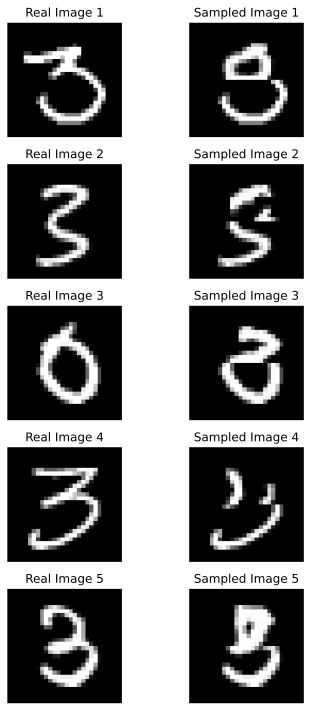

In [ ]:
imgs, _ = next(iter(train_loader))

imgs = imgs[:5].to(device)
# slice images
real_imgs = [imgs[i:i+1] for i in range(5)]

# sample images given bottom half
sampled_imgs = [sample_top_half_given_bottom(model_1, real_img, num_steps=100, burnin=95) for real_img in real_imgs]

# show real and sampled images side by side
fig, axs = plt.subplots(5, 2, figsize=(6, 10))

for i, (real_img, sampled_img) in enumerate(zip(real_imgs, sampled_imgs)):
    axs[i, 0].imshow(real_img[0, 0].cpu(), cmap='gray')
    axs[i, 0].set_title(f"Real Image {i+1}")
    axs[i, 0].axis('off')

    axs[i, 1].imshow(sampled_img[0, 0].cpu(), cmap='gray')
    axs[i, 1].set_title(f"Sampled Image {i+1}")
    axs[i, 1].axis('off')

plt.tight_layout()
plt.show()